In [192]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

import glob
import sys
import os
from collections import OrderedDict

import csv

sys.path.insert(0, "../casa/")
from plot_utils import *
from genome_utils import *

In [193]:
# Guide score files
F1R1_fn = '../data/FASTQ/FADS1_rep8detailed.txt'
F1R2_fn = '../data/FASTQ/FADS1_rep9detailed.txt'

F2R1_fn = '../data/FASTQ/FADS2_rep8detailed.txt'
F2R2_fn = '../data/FASTQ/FADS2_rep11detailed.txt'

F3R1_fn = '../data/FASTQ/FADS3_rep7detailed.txt'
F3R2_fn = '../data/FASTQ/FADS3_rep8detailed.txt'

FnR1_fn = '../data/FASTQ/FEN1_rep11detailed.txt'
FnR2_fn = '../data/FASTQ/FEN1_rep12detailed.txt'

F1C1_fn = '../data/FADS1_cutting_v2__detailed.txt'
F3C1_fn = '../data/FADS3_cutting_v2__detailed.txt'

fn_list = [F1R1_fn,F1R2_fn,F2R1_fn,F2R2_fn,
           F3R1_fn,F3R2_fn,FnR1_fn,FnR2_fn,
           F1C1_fn,F3C1_fn]

exp_ids = ['F1R1','F1R2','F2R1','F2R2',
           'F3R1','F3R2','FnR1','FnR2',
           'F1C1','F3C1']

fullinfo= [("FADS1",1), ("FADS1",2), ("FADS2",1), ("FADS2",2), 
           ("FADS3",1), ("FADS3",2), ("FEN1",1), ("FEN1",2),
           ("F1cut",1), ("F3cut",1)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [194]:
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
F1R1_bed= '../data/FADS1_rep8__fixPeaks.bed'
F1R2_bed= '../data/FADS1_rep9__fixPeaks.bed'

F2R1_bed= '../data/FADS2_rep8__rescore_fixPeaks.bed'
F2R2_bed= '../data/FADS2_rep11__rescore_fixPeaks.bed'

F3R1_bed= '../data/FADS3_rep7__rescore_fixPeaks.bed'
F3R2_bed= '../data/FADS3_rep8__rescore_fixPeaks.bed'

FnR1_bed= '../data/FEN1_rep11__rescore_fixPeaks.bed'
FnR2_bed= '../data/FEN1_rep12__rescore_fixPeaks.bed'

F1C1_bed= '../data/FADS1_cutting_v2__lowresPeaks.bed'
F3C1_bed= '../data/FADS3_cutting_v2__lowresPeaks.bed'

exp_beds= [F1R1_bed, F1R2_bed, F2R1_bed, F2R2_bed, 
           F3R1_bed, F3R2_bed, FnR1_bed, FnR2_bed,
           F1C1_bed, F3C1_bed]

K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'

extra_beds = [ K27_bed, DHS_bed ]
extra_tags = [ 'k27', 'DHS' ]

In [195]:
# Target BEDs for post-processed peak calls
# Maintain relative assay target ordering
F1_targ = '../data/FADS1__replicatingPeaks.bed'

F2_targ = '../data/FADS2__replicatingPeaks.bed'

F3_targ = '../data/FADS3__replicatingPeaks.bed'

Fn_targ = '../data/FEN1__replicatingPeaks.bed'

BED_dump = [F1_targ, F2_targ, F3_targ, Fn_targ]

In [196]:
gff = pd.read_table('../data/FADS_locus.gff')

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [197]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,geneID
0,ENST00000542506.5,chr11,-,61802312,61815291,61802410,61813305,12,"61802312,61802800,61803031,61803362,61803669,6...","61802462,61802926,61803111,61803459,61803767,6...",FADS1
1,ENST00000257261.10,chr11,+,61816255,61867354,61816285,61865689,12,"61816255,61837777,61840333,61840623,61848158,6...","61816426,61837888,61840531,61840725,61848284,6...",FADS2
2,ENST00000305885.3,chr11,+,61792910,61797238,61795361,61796504,2,"61792910,61795340","61793028,61797238",FEN1
3,ENST00000278829.7,chr11,-,61873525,61891545,61873813,61891381,12,"61873525,61875850,61876110,61876358,61876865,6...","61873865,61875976,61876190,61876455,61876963,6...",FADS3


In [198]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [199]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [200]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [201]:
# Get experimental peaks
## Read in files
test_peaks = [ pd.read_table(
                 fn,sep='\t',header=None,
                 names=['chr','start','end','hdr','pass','strand']
               ) 
               for fn in exp_beds ]
## Figure out which chromosomes were tested
tested_chr = pd.concat( test_peaks, axis=0 )['chr'].unique()
## Filter out non-significant peaks
test_peaks = [ merge_bed(
                   df.loc[ df['pass'] == True, ('chr','start','end') ].copy()
               )
               for df in test_peaks ]
## Filter out tiny peaks
test_peaks = [ df[ (df['end'] - df['start']) > 100 ] if 'cut' not in fullinfo[i][0] 
               else df[ (df['end'] - df['start']) > 50 ]
               for i, df in enumerate(test_peaks) ]

print("Experimental track count: {}".format(len(test_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ test_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print("Total track count: {}".format(len(test_peaks)))
for exp_id, peaks_idx in zip(exp_ids+extra_tags,range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: read_table is deprecated, use read_csv instead.


Experimental track count: 10
Total track count: 12


FADS1
3
FADS3
8
F1cut
4200
F3cut
4200


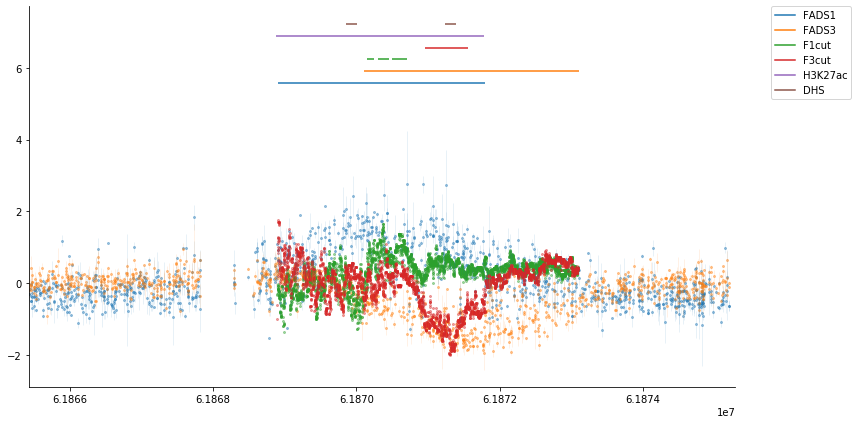

In [202]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61865430,61875290]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F3R1','F3R2','F1C1','F3C1','k27','DHS'])


FADS1
1
FADS3
3
F1cut
2900
F3cut
2900


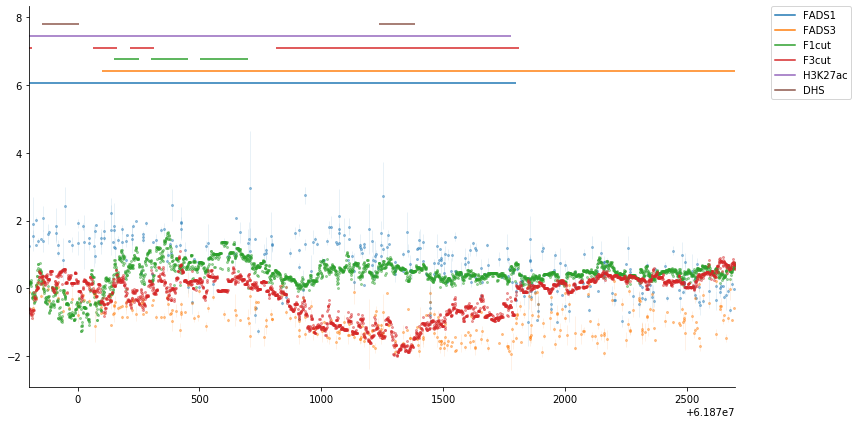

In [168]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61870000-200,61872700]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F3R1','F3R2','F1C1','F3C1','k27','DHS'])


FADS1
0
FADS3
1
F1cut
500
F3cut
500


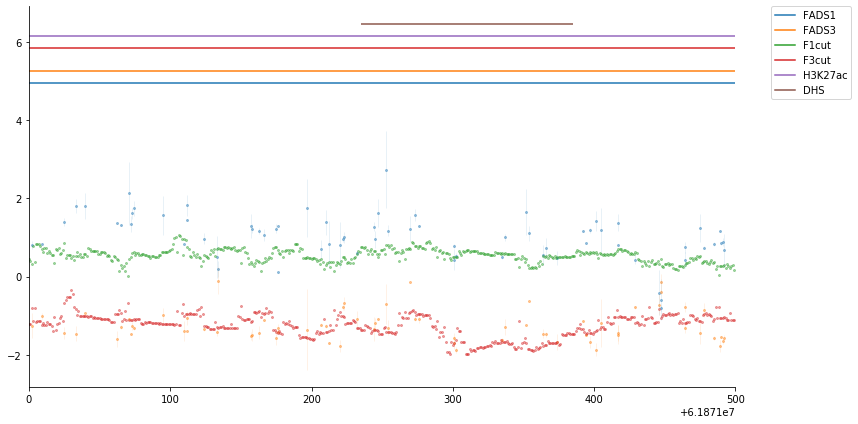

In [169]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61871000,61871500]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F3R1','F3R2','F1C1','F3C1','k27','DHS'])


In [164]:
data.loc[(data['cutsite'] > 61870200) & (data['cutsite'] < 61870700),'F1C1']

chr11:61870183-61870205:+         NaN
chr11:61870204-61870205:+    0.394129
chr11:61870205-61870206:+    0.537393
chr11:61870205-61870227:+         NaN
chr11:61870206-61870207:+    0.523248
chr11:61870207-61870208:+    0.390106
chr11:61870208-61870209:+    0.531324
chr11:61870209-61870210:+    0.661949
chr11:61870210-61870211:+    0.647103
chr11:61870210-61870232:+         NaN
chr11:61870211-61870212:+    0.624154
chr11:61870212-61870213:+    0.630995
chr11:61870213-61870214:+    0.471775
chr11:61870214-61870215:+    0.616057
chr11:61870215-61870216:+    0.711037
chr11:61870216-61870217:+    0.716259
chr11:61870217-61870218:+    0.691391
chr11:61870218-61870219:+    0.599118
chr11:61870219-61870220:+    0.612875
chr11:61870220-61870221:+    0.641678
chr11:61870220-61870242:-         NaN
chr11:61870221-61870222:+    0.642029
chr11:61870222-61870223:+    0.644439
chr11:61870223-61870224:+    0.793742
chr11:61870224-61870225:+    0.640468
chr11:61870225-61870226:+    0.594165
chr11:618702

In [144]:
test_peaks[test_peaks['assay']=='F3cut']

,chr,start,end,exp_id,assay,replicate
54,chr11,61868213,61868313,F3C1,F3cut,1
55,chr11,61868413,61868563,F3C1,F3cut,1
56,chr11,61868813,61868913,F3C1,F3cut,1
57,chr11,61869563,61869663,F3C1,F3cut,1
58,chr11,61869713,61869813,F3C1,F3cut,1
59,chr11,61870063,61870163,F3C1,F3cut,1
60,chr11,61870213,61870313,F3C1,F3cut,1
61,chr11,61870813,61871813,F3C1,F3cut,1


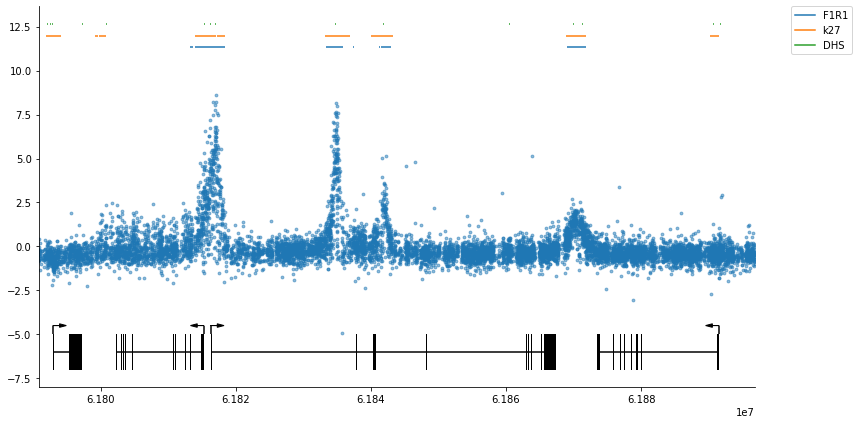

In [11]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff)

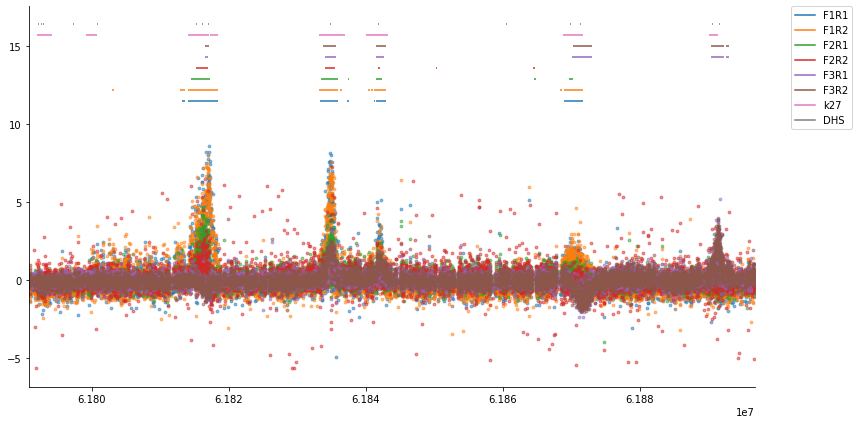

In [12]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


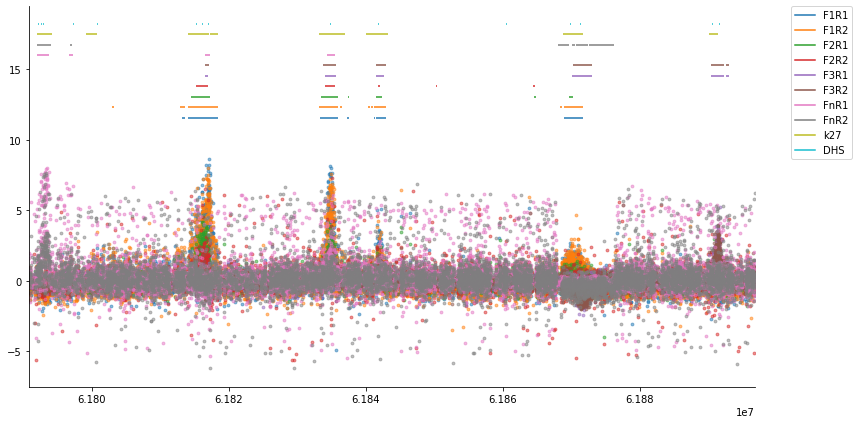

In [13]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])


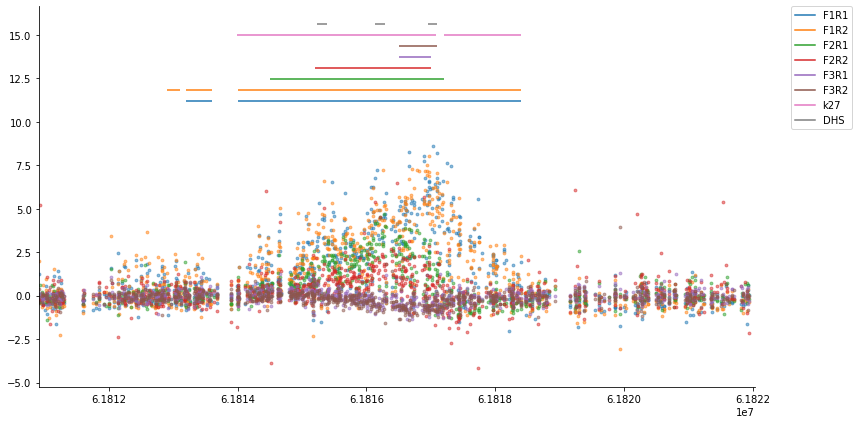

In [14]:
fig_h = plot_hff_cutsites(np.array([[61810908,61822034]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


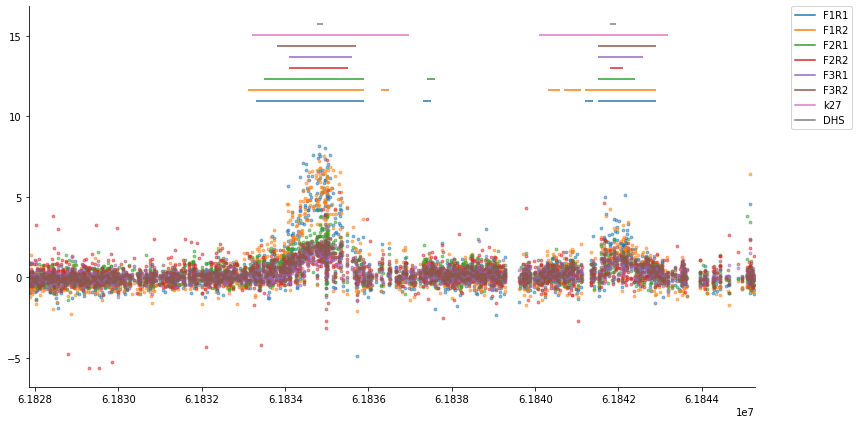

In [15]:
fig_h = plot_hff_cutsites(np.array([[61827852,61845270]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


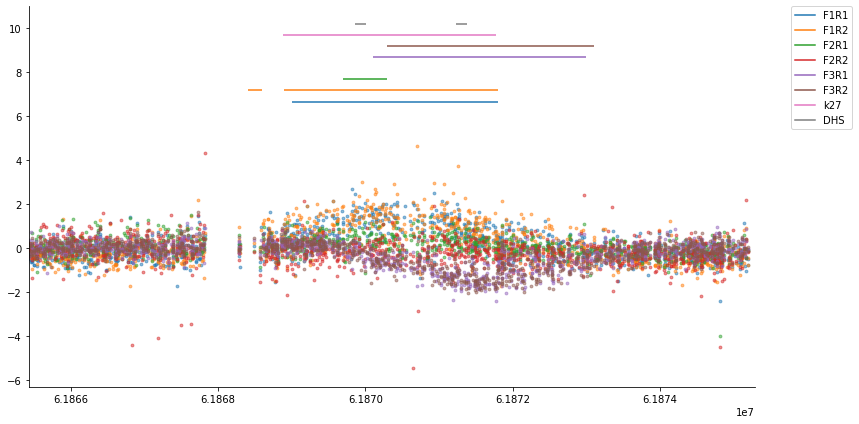

In [16]:
fig_h = plot_hff_cutsites(np.array([[61865430,61875290]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


FADS1
1
FADS2
0
FADS3
9
FEN1
1


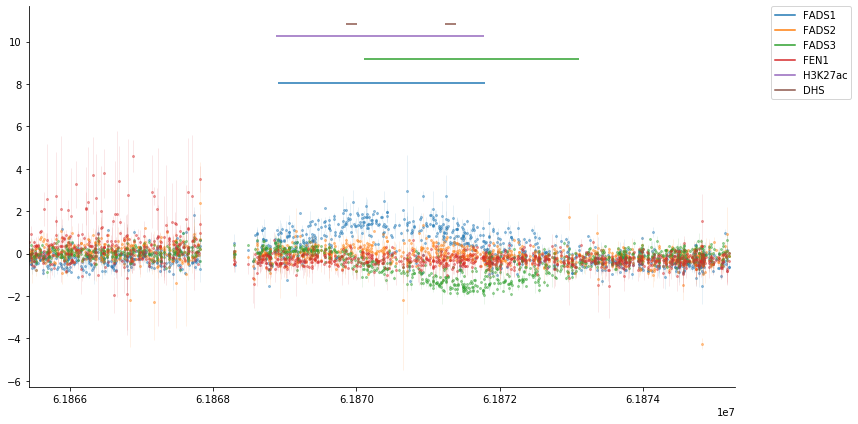

In [17]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61865430,61875290]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])
fig_h.savefig('FADS_locus__61865430_61875290__all.pdf')

In [20]:
test_peaks[test_peaks['assay'] == 'F1cut']

,chr,start,end,exp_id,assay,replicate
51,chr11,61868293,61868353,F1C1,F1cut,1
52,chr11,61869963,61870053,F1C1,F1cut,1
53,chr11,61870623,61870683,F1C1,F1cut,1


FADS1
1
FADS2
0
FADS3
6


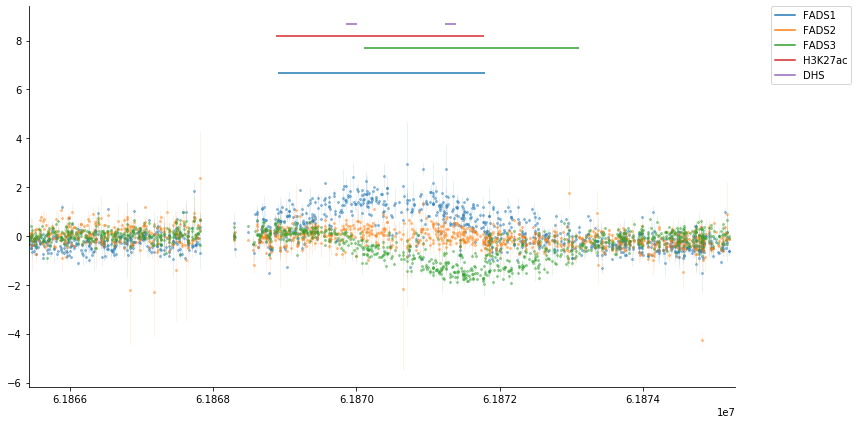

In [19]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61865430,61875290]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61865430_61875290__noFEN1.pdf')

FADS1
17
FADS2
11
FADS3
27


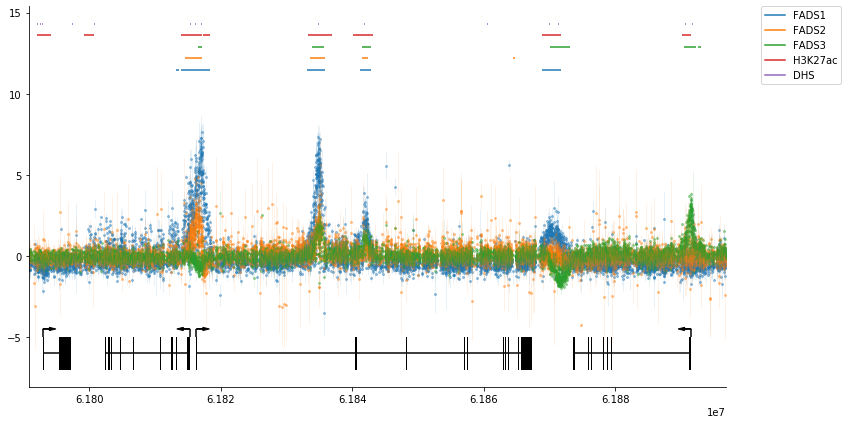

In [20]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])

draw_genes_from_gff(ax_h, gff)


FADS1
17
FADS2
11
FADS3
27
FEN1
48


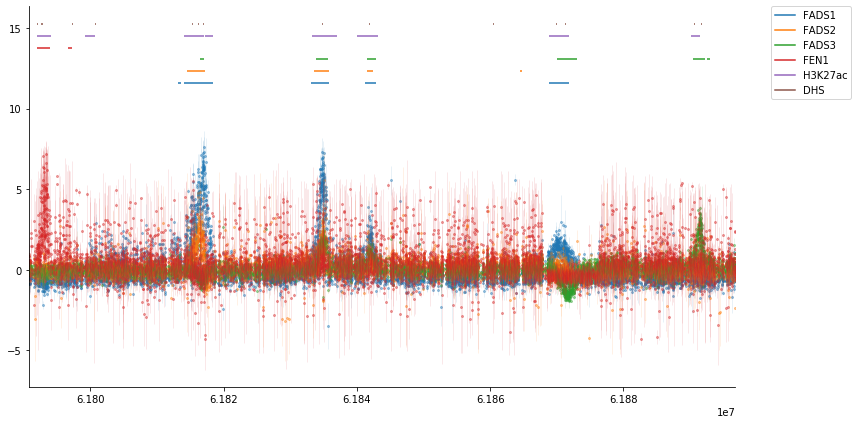

In [21]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])


FADS1
17


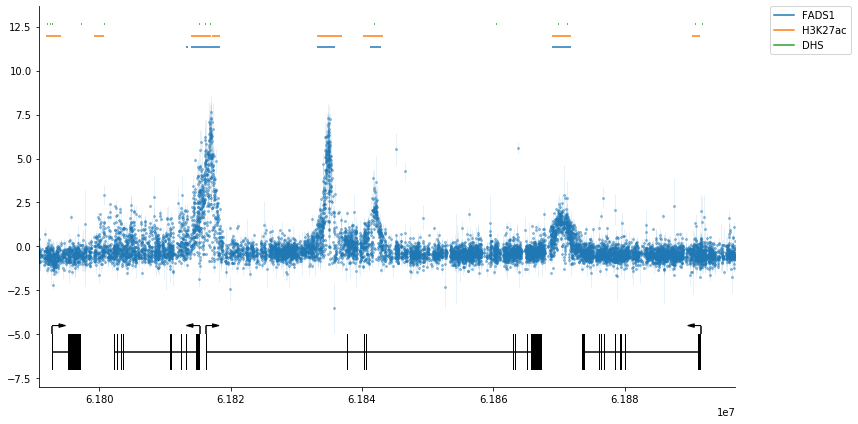

In [22]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','k27','DHS'])

draw_genes_from_gff(ax_h, gff)

FADS2
11


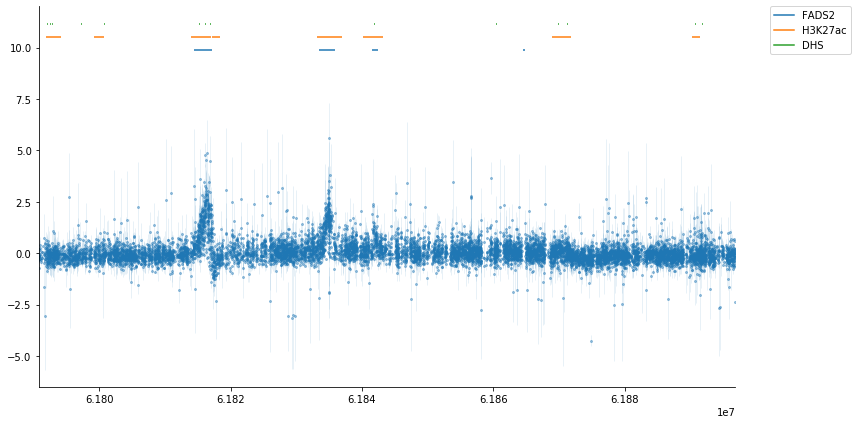

In [23]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F2R1','F2R2','k27','DHS'])


FADS3
27


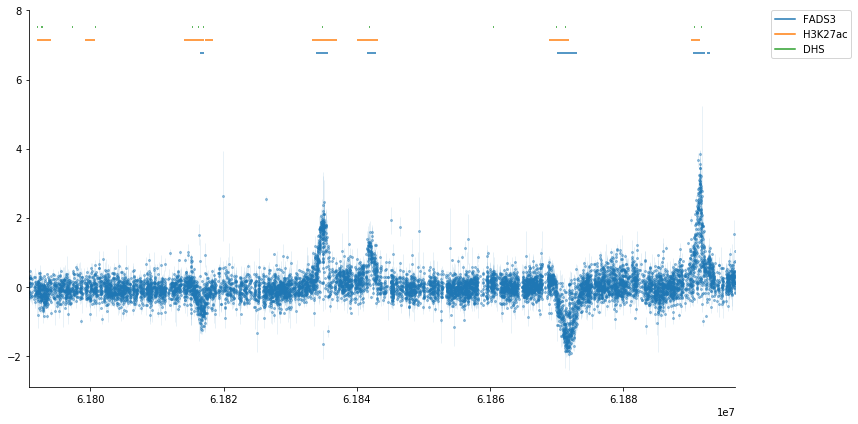

In [24]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F3R1','F3R2','k27','DHS'])


FEN1
48


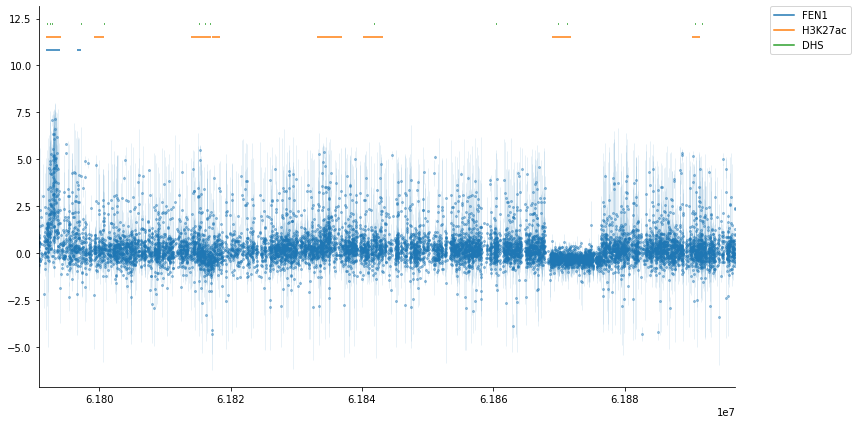

In [25]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['FnR1','FnR2','k27','DHS'])


FEN1
19


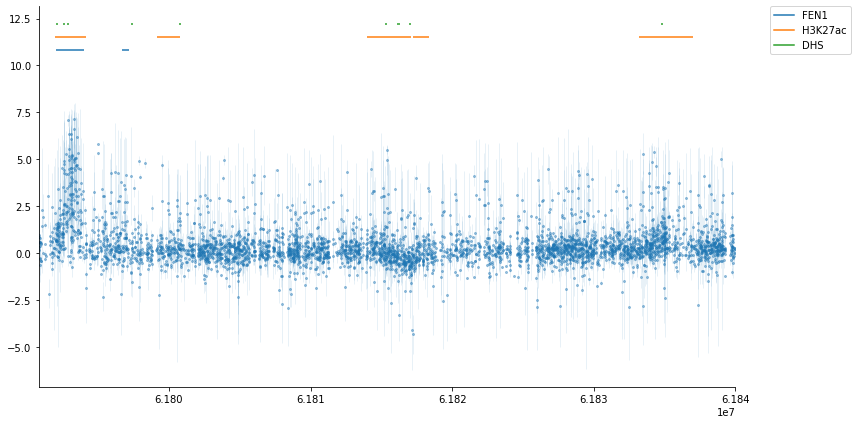

In [26]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61840000]]), 
                  data, test_peaks, plot_ids=['FnR1','FnR2','k27','DHS'])


FADS1
2
FADS2
1
FADS3
1


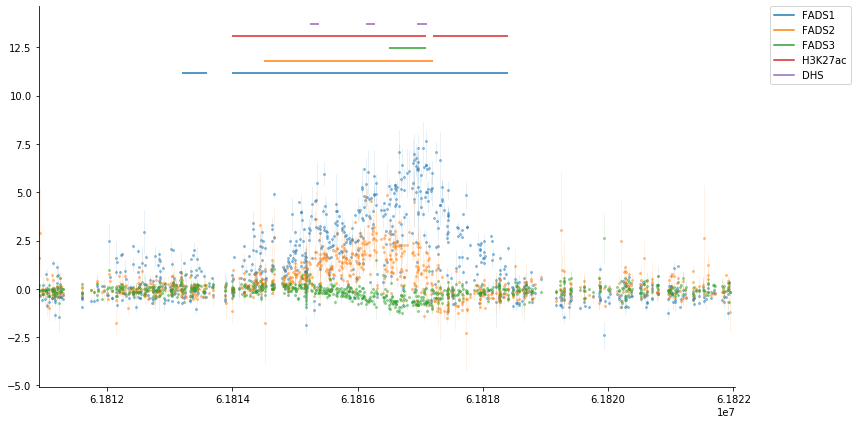

In [27]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61810908,61822034]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61810908_61822034__noFEN1.pdf')

FADS1
4
FADS2
3
FADS3
6


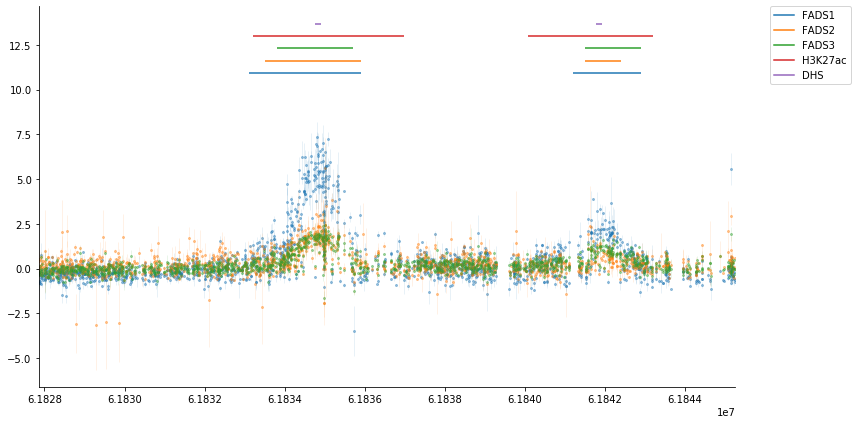

In [28]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61827852,61845270]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61827852_61845270__noFEN1.pdf')

# Connection diagram

In [29]:
txn_starts = extract_txn_starts(gff)

pack_TSSs   = [('FADS1',txn_starts['FADS1'][0],txn_starts['FADS1'][1]),
               ('FADS2',txn_starts['FADS2'][0],txn_starts['FADS2'][1]),
               ('FADS3',txn_starts['FADS3'][0],txn_starts['FADS3'][1]),
               ('FEN1',txn_starts['FEN1'][0],txn_starts['FEN1'][1])
              ]

In [30]:
txn_starts

{'FADS1': ('chr11', 61815291),
 'FADS2': ('chr11', 61816255),
 'FEN1': ('chr11', 61792910),
 'FADS3': ('chr11', 61891545)}

In [31]:
all_locus_peaks = get_replicating_peaks(test_peaks)

In [32]:
# FADS1
FADS1_total_scores = get_peak_strengths(F1R1_bed, F1R2_bed)

# FADS2
FADS2_total_scores = get_peak_strengths(F2R1_bed, F2R2_bed)

# FADS3
FADS3_total_scores = get_peak_strengths(F3R1_bed, F3R2_bed)

# FEN1
FEN1_total_scores  = get_peak_strengths(FnR1_bed, FnR2_bed)


pack_scores = [FADS1_total_scores, FADS2_total_scores, FADS3_total_scores, FEN1_total_scores]


../hcr-ff/plot_utils.py:312: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  for fn in argv ]


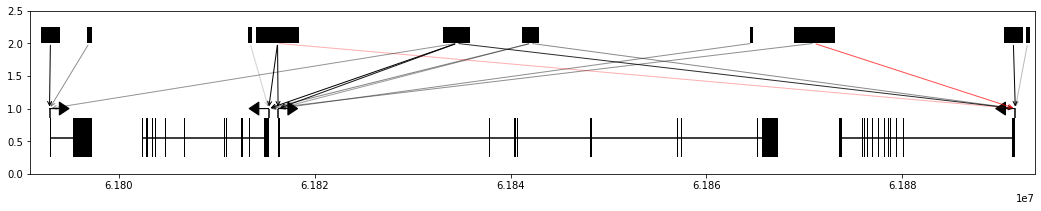

In [33]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores)

plt.savefig('FADS_locus__full_locus__connectogram.pdf')

plt.show()

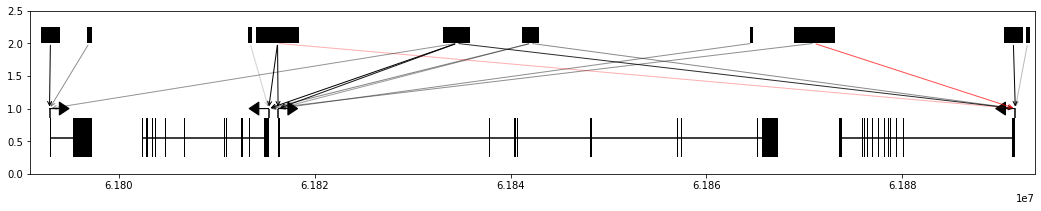

In [34]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores)
plt.show()

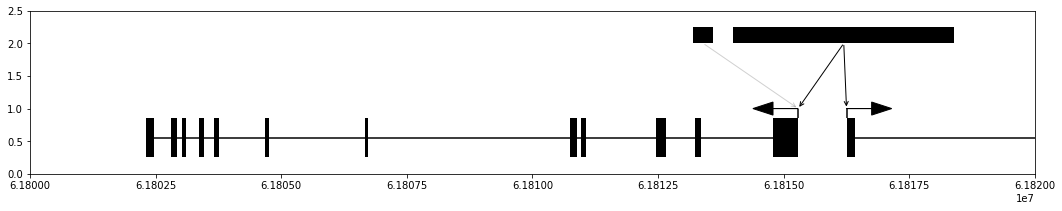

In [35]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [61800000,61820000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores, xlims=glims)

plt.savefig('FADS_locus__61800000_61820000__connectogram.pdf')

plt.show()

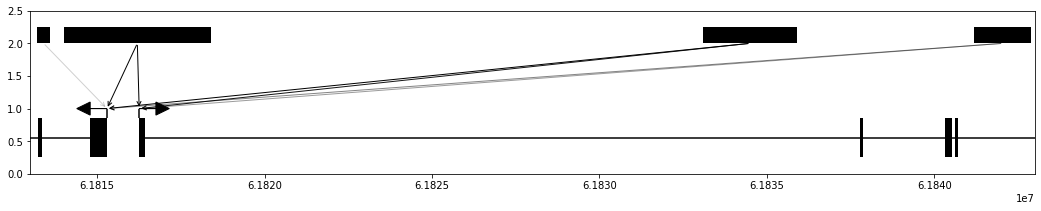

In [36]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [61813000,61843000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores, xlims=glims)

plt.savefig('FADS_locus__61813000_61843000__connectogram.pdf')

plt.show()

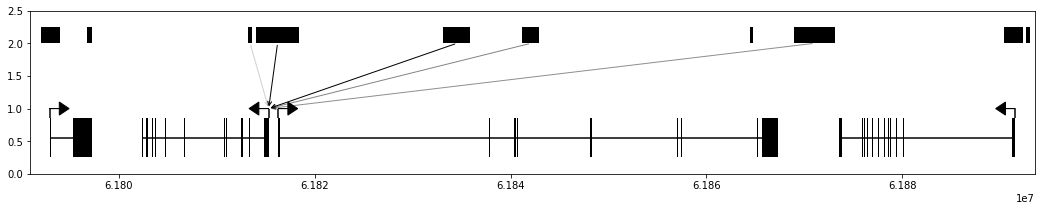

In [37]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores)

plt.savefig('FADS1__full_locus__connectogram.pdf')

plt.show()

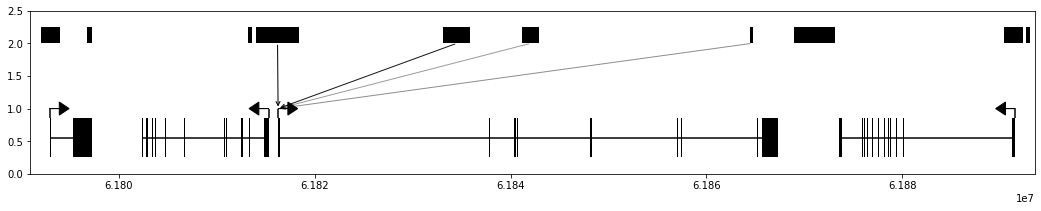

In [38]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores)

plt.savefig('FADS2__full_locus__connectogram.pdf')

plt.show()

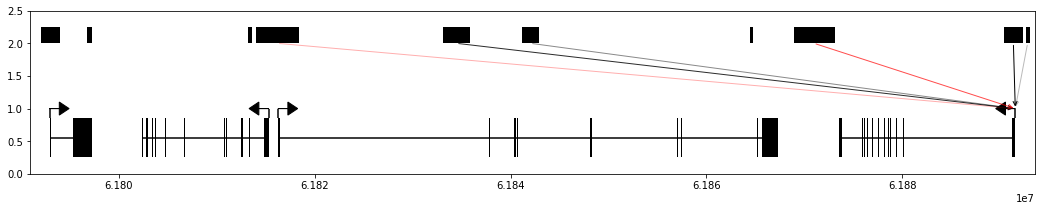

In [39]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores)

plt.savefig('FADS3__full_locus__connectogram.pdf')

plt.show()

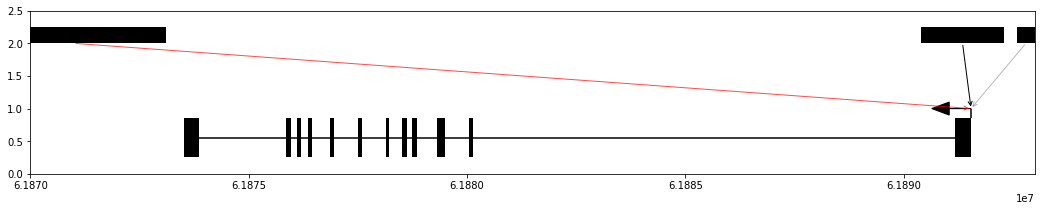

In [40]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [61870000,61893000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
#connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores, xlims=glims)
#connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores, xlims=glims)
#connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores, xlims=glims)

plt.savefig('FADS_locus__61863000_61893000__connectogram.pdf')

plt.show()

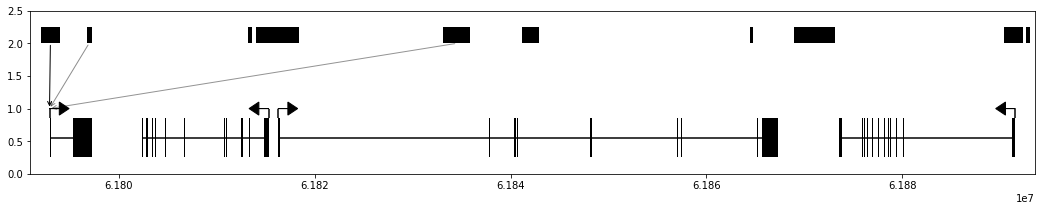

In [41]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores)

plt.savefig('FEN1__full_locus__connectogram.pdf')

plt.show()

# Add FADS locus variants to connect-o-gram

In [42]:
SNP_data = pd.read_table('../data/SNPS_metadata_hg38.txt',header=0).dropna()
SNP_data['pos'] = [ int(snp_id.split(':')[1]) for snp_id in SNP_data['hg38_ID'] ]
SNP_data['MAF'] = [ min(daf,1-daf) for daf in SNP_data['EUR_allele_Freq'] ]

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [43]:
SNP_data

,hg38_ID,EUR_allele_Freq,is_eQTL,is_GWAS/Trait,pos,MAF
0,chr11:61887833:A:G,0.7286,True,True,61887833,0.2714
1,chr11:61790354:T:C,0.3489,True,True,61790354,0.3489
2,chr11:61790331:T:C,0.3628,True,True,61790331,0.3628
3,chr11:61889873:G:A,1.0000,False,False,61889873,0.0000
4,chr11:61889405:G:A,0.9990,False,False,61889405,0.0010
5,chr11:61841976:A:G,0.0338,False,False,61841976,0.0338
6,chr11:61870762:G:C,0.8777,False,False,61870762,0.1223
7,chr11:61889723:T:G,0.0020,False,False,61889723,0.0020
8,chr11:61849939:G:A,0.0000,False,False,61849939,0.0000
9,chr11:61864139:G:A,0.0020,False,False,61864139,0.0020


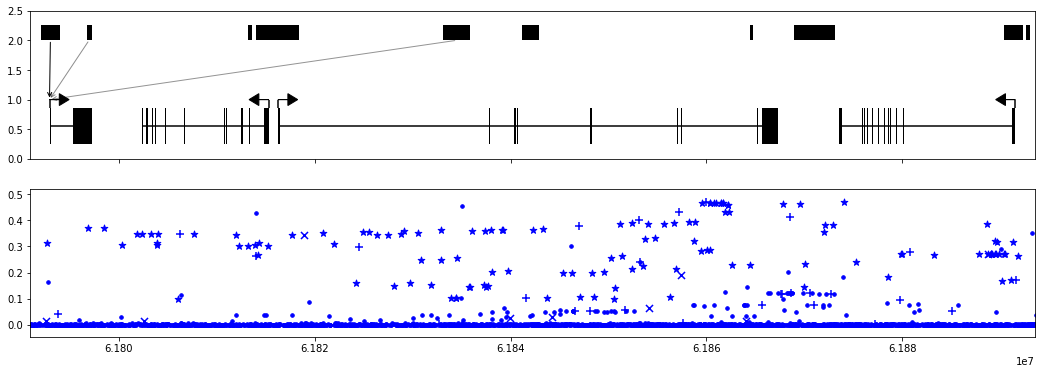

In [44]:
fig, axes  = plt.subplots(2,1,figsize=(18,6),sharex=True)
ax = axes[0]
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores)

ax = axes[1]
both_hits = SNP_data[SNP_data['is_GWAS/Trait'] & SNP_data['is_eQTL']]
gwas_only = SNP_data[~(SNP_data['is_GWAS/Trait'] & SNP_data['is_eQTL']) & SNP_data['is_GWAS/Trait']]
eqtl_only = SNP_data[~(SNP_data['is_GWAS/Trait'] & SNP_data['is_eQTL']) & SNP_data['is_eQTL']]
none_hits = SNP_data[~(SNP_data['is_GWAS/Trait'] | SNP_data['is_eQTL'])]
ax.scatter(gwas_only['pos'],gwas_only['MAF'],s=50.0,marker="+",color='blue')
ax.scatter(eqtl_only['pos'],eqtl_only['MAF'],s=50.0,marker="x",color='blue')
ax.scatter(both_hits['pos'],both_hits['MAF'],s=50.0,marker="*",color='blue')
ax.scatter(none_hits['pos'],none_hits['MAF'],s=50.0,marker=".",color='blue')

plt.show()

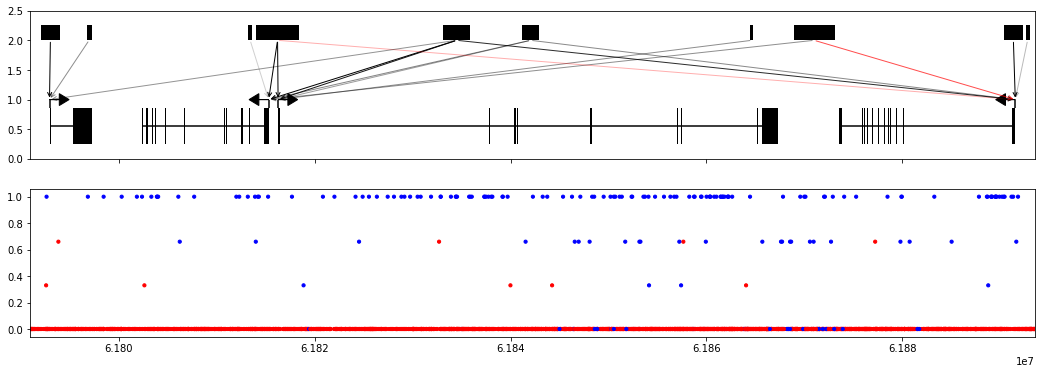

In [45]:
fig, axes  = plt.subplots(2,1,figsize=(18,6),sharex=True)
ax = axes[0]

ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores)

dummy = np.linspace(0,1,21)

ax = axes[1]
both_hits = SNP_data[SNP_data['is_GWAS/Trait'] & SNP_data['is_eQTL']]
gwas_only = SNP_data[~(SNP_data['is_GWAS/Trait'] & SNP_data['is_eQTL']) & SNP_data['is_GWAS/Trait']]
eqtl_only = SNP_data[~(SNP_data['is_GWAS/Trait'] & SNP_data['is_eQTL']) & SNP_data['is_eQTL']]
none_hits = SNP_data[~(SNP_data['is_GWAS/Trait'] | SNP_data['is_eQTL'])]

ax.scatter(both_hits['pos'],
           np.repeat(1.0,both_hits.shape[0]),
           s=40.0,marker=".",color=[ 'blue' if g_hit else 'red' for g_hit in (both_hits['MAF'].values.reshape(-1) > 0.05) ])
ax.scatter(gwas_only['pos'],
           np.repeat(0.66,gwas_only.shape[0]),
           s=40.0,marker=".",color=[ 'blue' if g_hit else 'red' for g_hit in (gwas_only['MAF'].values.reshape(-1) > 0.05) ])
ax.scatter(eqtl_only['pos'],
           np.repeat(0.33,eqtl_only.shape[0]),
           s=40.0,marker=".",color=[ 'blue' if g_hit else 'red' for g_hit in (eqtl_only['MAF'].values.reshape(-1) > 0.05) ])
ax.scatter(none_hits['pos'],
           np.repeat(0.0,none_hits.shape[0]),
           s=40.0,marker=".",color=[ 'blue' if g_hit else 'red' for g_hit in (none_hits['MAF'].values.reshape(-1) > 0.05) ])

plt.savefig('FADS__connectogram_with_SNPs.pdf')

plt.show()

# Export replicating peaks

In [46]:
FADS1_only_peaks = get_replicating_peaks( test_peaks[(test_peaks['assay'] == 'FADS1')] )
FADS2_only_peaks = get_replicating_peaks( test_peaks[(test_peaks['assay'] == 'FADS2')] )
FADS3_only_peaks = get_replicating_peaks( test_peaks[(test_peaks['assay'] == 'FADS3')] )
FEN1_only_peaks  = get_replicating_peaks( test_peaks[(test_peaks['assay'] == 'FEN1')] )

pack_peaks       = [FADS1_only_peaks, FADS2_only_peaks, FADS3_only_peaks, FEN1_only_peaks]

In [46]:
write_bed_format(pack_peaks, pack_scores, pack_TSSs, '../data/FADS_locus__replicatingPeaks.bed')


# Effector directionality analysis

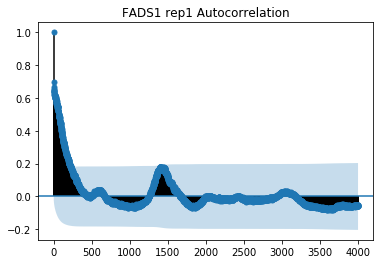

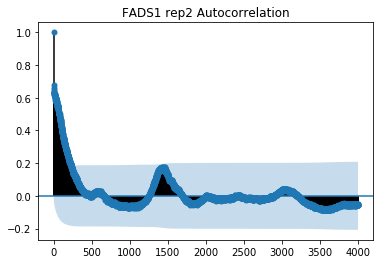

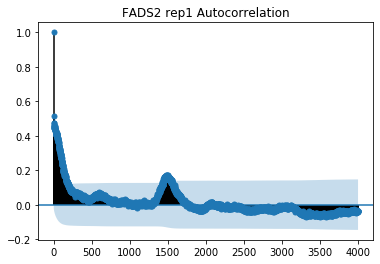

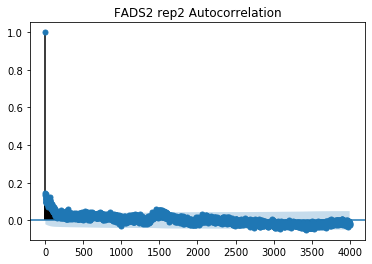

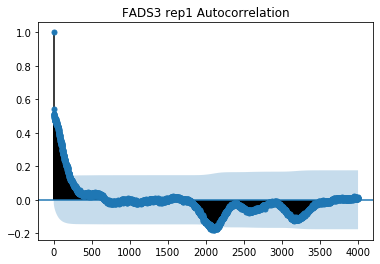

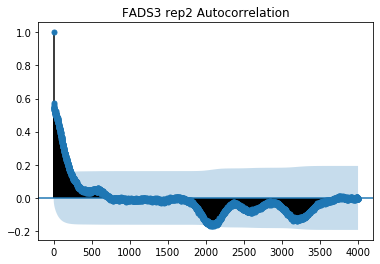

In [47]:
plot_acf( data['F1R1'], lags=4000, title='FADS1 rep1 Autocorrelation' )
plt.savefig('FADS1_rep1__autocorrelation.pdf')
plt.show()
plot_acf( data['F1R2'], lags=4000, title='FADS1 rep2 Autocorrelation' );
plt.savefig('FADS1_rep2__autocorrelation.pdf')
plt.show()
plot_acf( data['F2R1'], lags=4000, title='FADS2 rep1 Autocorrelation' );
plt.savefig('FADS2_rep1__autocorrelation.pdf')
plt.show()
plot_acf( data['F2R2'], lags=4000, title='FADS2 rep2 Autocorrelation' );
plt.savefig('FADS2_rep2__autocorrelation.pdf')
plt.show()
plot_acf( data['F3R1'], lags=4000, title='FADS3 rep1 Autocorrelation' );
plt.savefig('FADS3_rep1__autocorrelation.pdf')
plt.show()
plot_acf( data['F3R2'], lags=4000, title='FADS3 rep2 Autocorrelation' );
plt.savefig('FADS3_rep2__autocorrelation.pdf')
plt.show()


In [48]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

Lag = 1: 0.6946353923795973


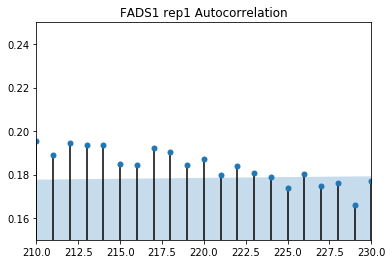

Lag = 1: 0.6802760684992314


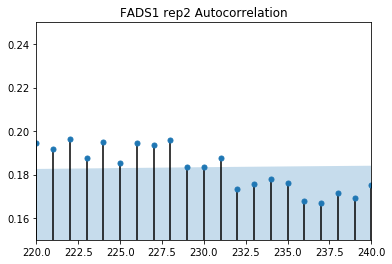

Lag = 1: 0.512380589117845


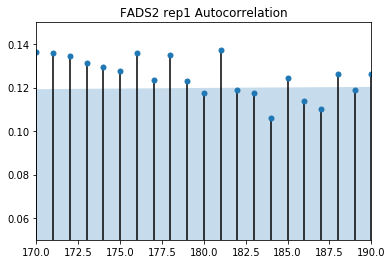

Lag = 1: 0.14371493224822526


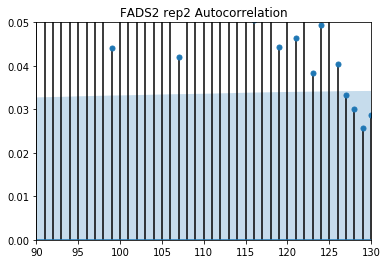

Lag = 1: 0.5419239227207213


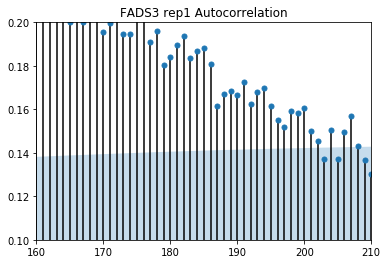

Lag = 1: 0.5754650159926036


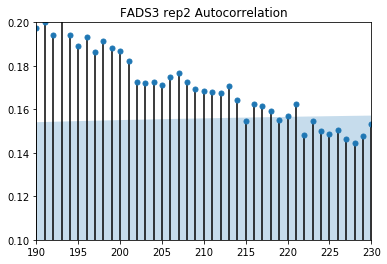

In [49]:
print("Lag = 1: {}".format(autocorr(data['F1R1'])[0,1]))
plot_acf( data['F1R1'], lags=250, title='FADS1 rep1 Autocorrelation' )
plt.xlim(210,230)
plt.ylim(0.15,0.25)
plt.show()
print("Lag = 1: {}".format(autocorr(data['F1R2'])[0,1]))
plot_acf( data['F1R2'], lags=250, title='FADS1 rep2 Autocorrelation' );
plt.xlim(220,240)
plt.ylim(0.15,0.25)
plt.show()
print("Lag = 1: {}".format(autocorr(data['F2R1'])[0,1]))
plot_acf( data['F2R1'], lags=250, title='FADS2 rep1 Autocorrelation' );
plt.xlim(170,190)
plt.ylim(0.05,0.15)
plt.show()
print("Lag = 1: {}".format(autocorr(data['F2R2'])[0,1]))
plot_acf( data['F2R2'], lags=250, title='FADS2 rep2 Autocorrelation' );
plt.xlim(90,130)
plt.ylim(0.00,0.05)
plt.show()
print("Lag = 1: {}".format(autocorr(data['F3R1'])[0,1]))
plot_acf( data['F3R1'], lags=250, title='FADS3 rep1 Autocorrelation' );
plt.xlim(160,210)
plt.ylim(0.10,0.20)
plt.show()
print("Lag = 1: {}".format(autocorr(data['F3R2'])[0,1]))
plot_acf( data['F3R2'], lags=250, title='FADS3 rep2 Autocorrelation' );
plt.xlim(190,230)
plt.ylim(0.10,0.20)
plt.show()


In [50]:
pos_strand = [ True if ':+' in x else False for x in data.index ]
neg_strand = [ True if ':-' in x else False for x in data.index ]

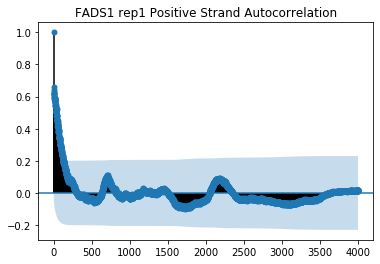

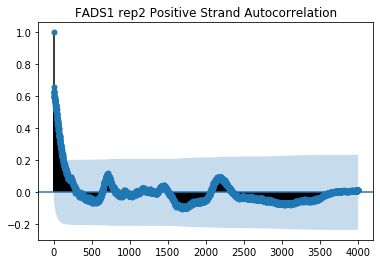

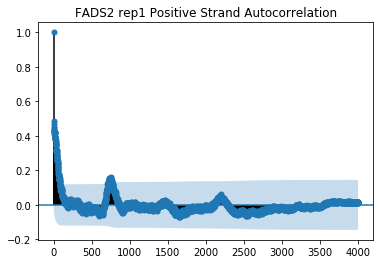

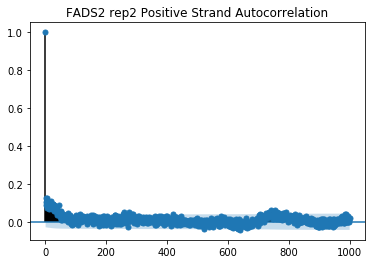

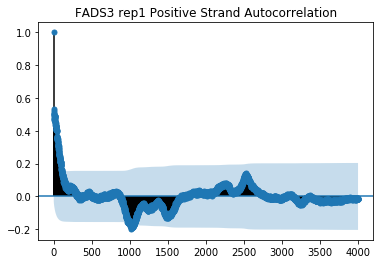

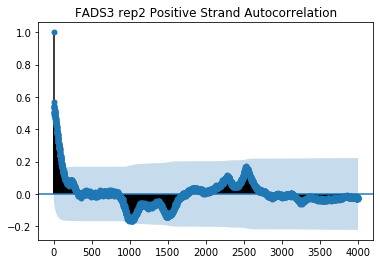

In [51]:
plot_acf( data.loc[pos_strand,'F1R1'], lags=4000, title='FADS1 rep1 Positive Strand Autocorrelation' )
plt.savefig('FADS1_rep1_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F1R2'], lags=4000, title='FADS1 rep2 Positive Strand Autocorrelation' );
plt.savefig('FADS1_rep2_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F2R1'], lags=4000, title='FADS2 rep1 Positive Strand Autocorrelation' );
plt.savefig('FADS2_rep1_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F2R2'], lags=1000, title='FADS2 rep2 Positive Strand Autocorrelation' );
plt.savefig('FADS2_rep2_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F3R1'], lags=4000, title='FADS3 rep1 Positive Strand Autocorrelation' );
plt.savefig('FADS3_rep1_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F3R2'], lags=4000, title='FADS3 rep2 Positive Strand Autocorrelation' );
plt.savefig('FADS3_rep2_pos__autocorrelation.pdf')
plt.show()


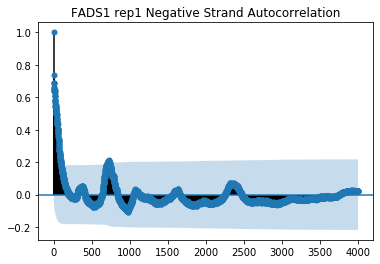

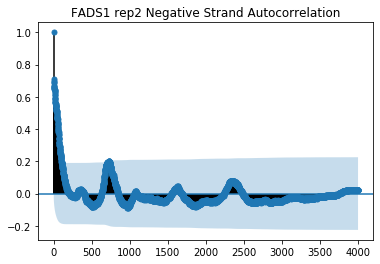

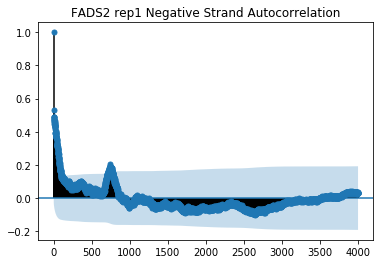

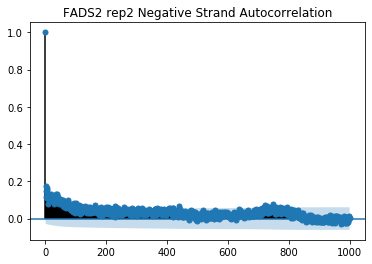

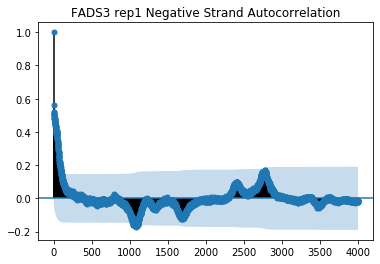

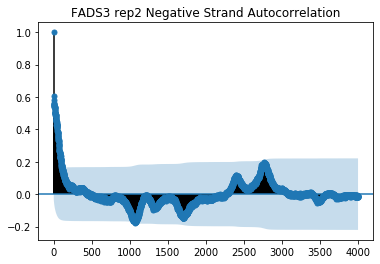

In [52]:
plot_acf( data.loc[neg_strand,'F1R1'], lags=4000, title='FADS1 rep1 Negative Strand Autocorrelation' )
plt.savefig('FADS1_rep1_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F1R2'], lags=4000, title='FADS1 rep2 Negative Strand Autocorrelation' );
plt.savefig('FADS1_rep2_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F2R1'], lags=4000, title='FADS2 rep1 Negative Strand Autocorrelation' );
plt.savefig('FADS2_rep1_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F2R2'], lags=1000, title='FADS2 rep2 Negative Strand Autocorrelation' );
plt.savefig('FADS2_rep2_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F3R1'], lags=4000, title='FADS3 rep1 Negative Strand Autocorrelation' );
plt.savefig('FADS3_rep1_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F3R2'], lags=4000, title='FADS3 rep2 Negative Strand Autocorrelation' );
plt.savefig('FADS3_rep2_neg__autocorrelation.pdf')
plt.show()


FADS1
4


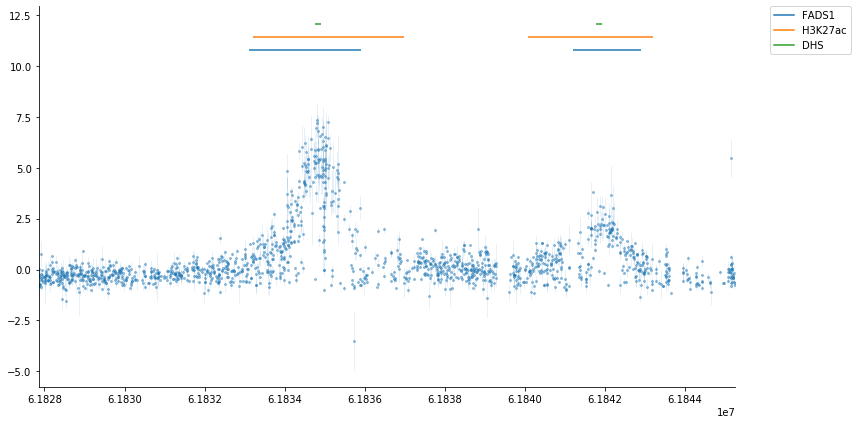

In [53]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61827852,61845270]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','k27','DHS'])
fig_h.savefig('FADS_locus__61827852_61845270__noFEN1.pdf')

In [54]:
data['strand'] = [ x.split(':')[-1] for x in data.index ]

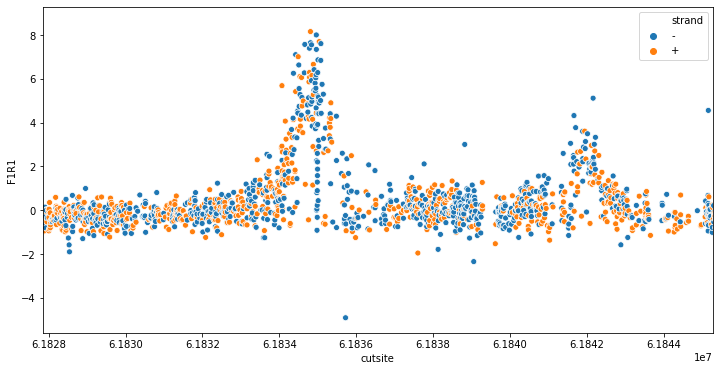

In [55]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(data=data,x='cutsite',y='F1R1',hue='strand')
ax.set_xlim([61827852,61845270])
fig.savefig('FADS_locus__strandeffectsFADS1.pdf')
plt.show()

# Subsetting analysis

In [56]:
S0R1_fn = '../data/FASTQ/FADS1_rep8detailed.txt'
S1R1_fn = 'subset_10__FADS1_rep8detailed.txt'
S2R1_fn = 'subset_20__FADS1_rep8detailed.txt'
S3R1_fn = 'subset_30__FADS1_rep8detailed.txt'
S4R1_fn = 'subset_40__FADS1_rep8detailed.txt'
S5R1_fn = 'subset_50__FADS1_rep8detailed.txt'
S6R1_fn = 'subset_60__FADS1_rep8detailed.txt'
S7R1_fn = 'subset_70__FADS1_rep8detailed.txt'
S8R1_fn = 'subset_80__FADS1_rep8detailed.txt'
S9R1_fn = 'subset_90__FADS1_rep8detailed.txt'

fn_list = [S0R1_fn,S1R1_fn,S2R1_fn,S3R1_fn,S4R1_fn,
           S5R1_fn,S6R1_fn,S7R1_fn,S8R1_fn,S9R1_fn]

exp_ids = ['S0R1','S1R1','S2R1','S3R1','S4R1',
           'S5R1','S6R1','S7R1','S8R1','S9R1']

fullinfo= [("Sub00",1), ("Sub10",1), ("Sub20",1), ("Sub30",1), ("Sub40",1), 
           ("Sub50",1), ("Sub60",1), ("Sub70",1), ("Sub80",1), ("Sub90",1)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [57]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [59]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [60]:
plus_offsets = [152, 147]
minus_offsets= [146, 153]
activ_area= np.array([ [ int(coord.split(':')[1].split('-')[1]) - plus_offsets[0],
                         int(coord.split(':')[1].split('-')[1]) + plus_offsets[1] ] if coord.split(':')[2] == '+' 
                       else [ int(coord.split(':')[1].split('-')[1]) - minus_offsets[0],
                              int(coord.split(':')[1].split('-')[1]) + minus_offsets[1] ]
                       for coord in data.index ])
activ_area= np.concatenate([np.full(shape=(activ_area.shape[0],1),fill_value='chr11',dtype=np.object),activ_area],axis=1)

In [61]:
activ_area

array([['chr11', 61788400, 61788699],
       ['chr11', 61788403, 61788702],
       ['chr11', 61788430, 61788729],
       ...,
       ['chr11', 61897005, 61897304],
       ['chr11', 61897008, 61897307],
       ['chr11', 61897004, 61897303]], dtype=object)

In [62]:
sorted(glob.glob('191125_subset/*__mergedPeaks.bed'))

['191125_subset/subset_00__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_10__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_20__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_30__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_40__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_50__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_60__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_70__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_80__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_90__FADS1_rep8detailed__mergedPeaks.bed']

In [63]:
test_peaks = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end']) for fn in sorted(glob.glob('191125_subset/*__mergedPeaks.bed')) ]
print(len(test_peaks))
extra_feat = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end'],usecols=[0,1,2]) for fn in ['../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed','../data/DNASE_peaks_replicated.bed'] ]
[ test_peaks.append( feat.loc[ feat['chr'] == 'chr11' ,:] ) for feat in extra_feat ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print(len(test_peaks))
for exp_id, peaks_idx in zip(['S0R1','S1R1','S2R1','S3R1','S4R1','S5R1','S6R1','S7R1','S8R1','S9R1','k27','DHS'],range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


10
12


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


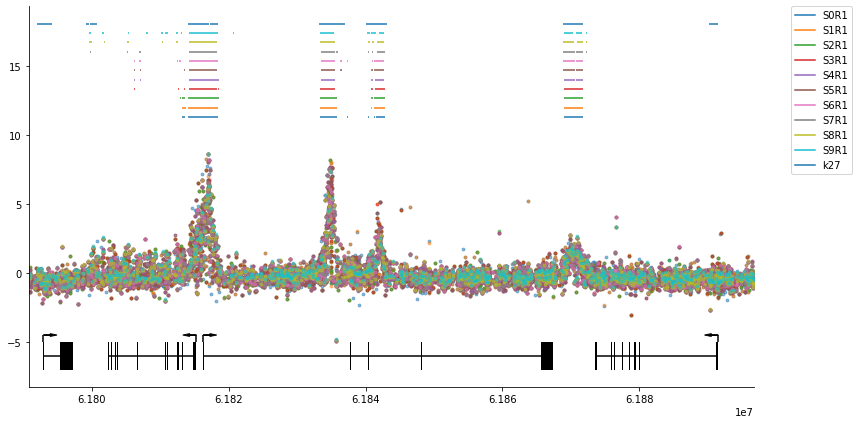

In [64]:
fig_h, ax_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['S0R1','S1R1','S2R1','S3R1','S4R1','S5R1','S6R1','S7R1','S8R1','S9R1','k27'])

draw_genes_from_gff(ax_h, gff)

fig_h.savefig('FADS_locus__subsettingFADS1.pdf')



In [65]:
strong_peaks = test_peaks.loc[test_peaks['assay']=='Sub00'.format(i),('chr','start','end')].values
allsub_peaks = test_peaks[test_peaks['assay'].str.contains('Sub')][~test_peaks['assay'].str.contains('Sub00')]
allsub_peaks = merge_bed(allsub_peaks.loc[:,('chr','start','end')])
slicer = np.vstack([ check_overlap([list(a_peak[1:3])],
                                   allsub_peaks.loc[:,('start','end')].values
                                  ) 
                     for a_peak in strong_peaks ]).any(axis=0)
weak_peaks   = allsub_peaks[ ~slicer ].values

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [66]:
strong_filter = [ sum(check_overlap(interval[1:3].astype(int), strong_peaks[:,1:3])) > 0 for interval in activ_area ]
weak_filter   = [ sum(check_overlap(interval[1:3].astype(int), weak_peaks[:,1:3])) > 0 for interval in activ_area ]
noPeak_filter = [ sum(check_overlap(interval[1:3].astype(int), weak_peaks[:,1:3])) == 0 for interval in activ_area ]

In [67]:
guide_effect_ = np.concatenate( [data[strong_filter].loc[:,'S0R1'].values, 
                                 data[weak_filter].loc[:,'S0R1'].values,
                                 data[noPeak_filter].loc[:,'S0R1'].values] )
strength_tag_ = np.concatenate( [np.full(shape=sum(strong_filter),fill_value='strong'), 
                                 np.full(shape=sum(weak_filter),fill_value='weak'),
                                 np.full(shape=sum(noPeak_filter),fill_value='inactive')] )

In [68]:
tidy_strength = pd.DataFrame({'activity': guide_effect_, "peak_strength": strength_tag_})

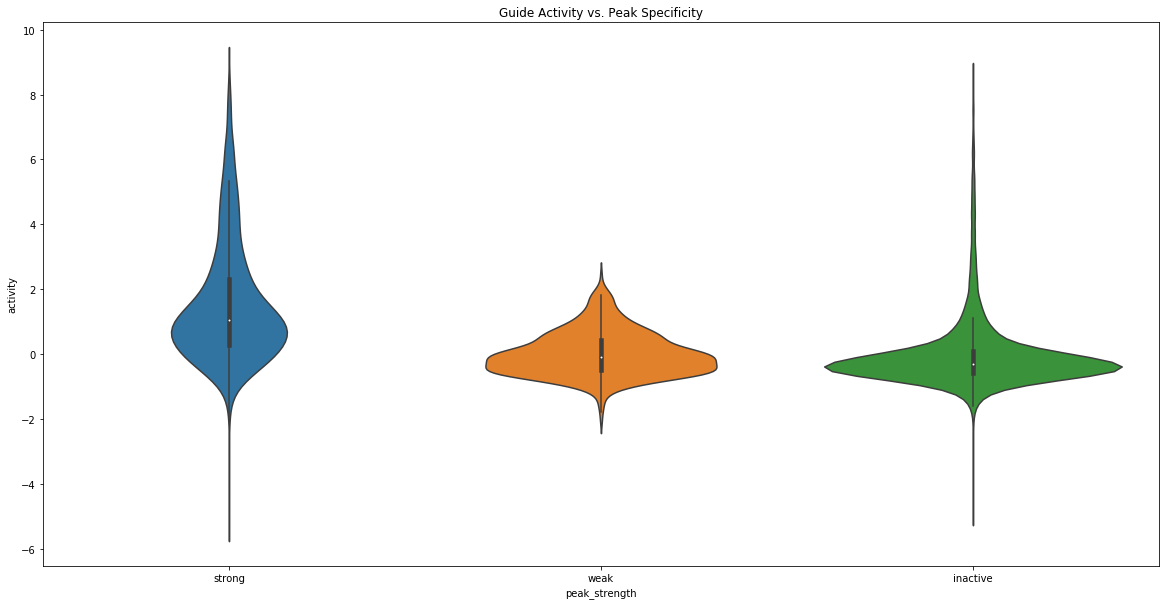

In [69]:
plt.figure(figsize=(20,10))
sns.violinplot(x='peak_strength',y='activity',data=tidy_strength, showfliers = False) \
  .set_title("Guide Activity vs. Peak Specificity");

plt.savefig('guide_score_in_peak_subsets.pdf')

In [70]:
overlap_with_k27ac = []
for i in range(10):
    hold_k27 = test_peaks.loc[test_peaks['assay']=='H3K27ac',('chr','start','end')].values
    hold_sub = test_peaks.loc[test_peaks['assay']=='Sub{}0'.format(i),('chr','start','end')].values
    total_sub_nt = sum(hold_sub[:,2] - hold_sub[:,1])
    inter_sub_nt = sum(intersect_bed3(hold_sub, hold_k27).loc[:,'end'] - intersect_bed3(hold_sub, hold_k27).loc[:,'start'])
    print("{}/{}={}".format(inter_sub_nt,total_sub_nt,inter_sub_nt/total_sub_nt))
    overlap_with_k27ac.append([inter_sub_nt,total_sub_nt])
    

11458/12200=0.9391803278688524
11458/12200=0.9391803278688524
11358/12400=0.9159677419354839
11030/11700=0.9427350427350427
10650/11400=0.9342105263157895
10882/11600=0.9381034482758621
10850/12200=0.889344262295082
10782/12000=0.8985
10545/11800=0.8936440677966102
10499/12900=0.813875968992248


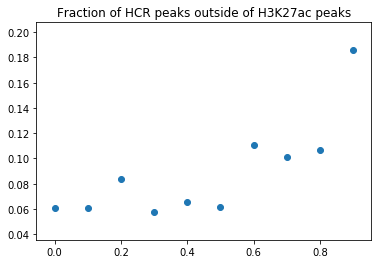

In [71]:
plt.scatter( np.arange(10)/10, [ (y-x)/y for x,y in overlap_with_k27ac ] )

plt.title("Fraction of HCR peaks outside of H3K27ac peaks")

plt.savefig("HCR_Histone_peak_inclusion_w_subsetting.pdf")

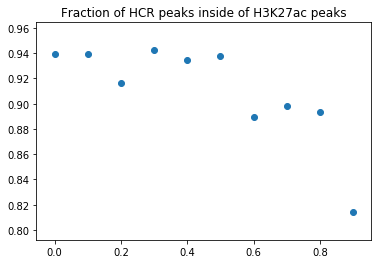

In [72]:
plt.scatter( np.arange(10)/10, [ x/y for x,y in overlap_with_k27ac ] )

plt.title("Fraction of HCR peaks inside of H3K27ac peaks")
plt.savefig("HCR_Histone_peak_exclusion_w_subsetting.pdf")

In [73]:
hold_k27 = test_peaks.loc[test_peaks['assay']=='H3K27ac',('chr','start','end')].values
hold_s10 = test_peaks.loc[test_peaks['assay']=='Sub10',('chr','start','end')].values

In [74]:
hold_k27[ (hold_k27[:,2] > 61815235) & (hold_k27[:,1] < 61871385) ]

array([['chr11', 61813997, 61817089],
       ['chr11', 61817207, 61818398],
       ['chr11', 61833216, 61836978],
       ['chr11', 61840084, 61843199],
       ['chr11', 61868883, 61871778]], dtype=object)

In [75]:
hold_s10

array([['chr11', 61813200, 61813700],
       ['chr11', 61814000, 61818400],
       ['chr11', 61833300, 61835900],
       ['chr11', 61840800, 61841000],
       ['chr11', 61841200, 61842800],
       ['chr11', 61868500, 61868600],
       ['chr11', 61869000, 61871800]], dtype=object)

In [76]:
sum(intersect_bed3(hold_s10, hold_k27).loc[:,'end'] - intersect_bed3(hold_s10, hold_k27).loc[:,'start'])

11458

In [77]:
sum(hold_s10[:,2] - hold_s10[:,1])

12200

# Some guide-wise summaries

In [78]:
# Guide score files
F1R1_fn = '../data/FASTQ/FADS1_rep8detailed.txt'
F1R2_fn = '../data/FASTQ/FADS1_rep9detailed.txt'

F2R1_fn = '../data/FASTQ/FADS2_rep8detailed.txt'
F2R2_fn = '../data/FASTQ/FADS2_rep11detailed.txt'

F3R1_fn = '../data/FASTQ/FADS3_rep7detailed.txt'
F3R2_fn = '../data/FASTQ/FADS3_rep8detailed.txt'

FnR1_fn = '../data/FASTQ/FEN1_rep11detailed.txt'
FnR2_fn = '../data/FASTQ/FEN1_rep12detailed.txt'

fn_list = [F1R1_fn,F1R2_fn,F2R1_fn,F2R2_fn,
           F3R1_fn,F3R2_fn,FnR1_fn,FnR2_fn]

exp_ids = ['F1R1','F1R2','F2R1','F2R2',
           'F3R1','F3R2','FnR1','FnR2']

fullinfo= [("FADS1",1), ("FADS1",2), ("FADS2",1), ("FADS2",2), 
           ("FADS3",1), ("FADS3",2), ("FEN1",1), ("FEN1",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [79]:
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
F1R1_bed= '../data/FADS1_rep8__fixPeaks.bed'
F1R2_bed= '../data/FADS1_rep9__fixPeaks.bed'

F2R1_bed= '../data/FADS2_rep8__rescore_fixPeaks.bed'
F2R2_bed= '../data/FADS2_rep11__rescore_fixPeaks.bed'

F3R1_bed= '../data/FADS3_rep7__rescore_fixPeaks.bed'
F3R2_bed= '../data/FADS3_rep8__rescore_fixPeaks.bed'

FnR1_bed= '../data/FEN1_rep11__rescore_fixPeaks.bed'
FnR2_bed= '../data/FEN1_rep12__rescore_fixPeaks.bed'

exp_beds= [F1R1_bed, F1R2_bed, F2R1_bed, F2R2_bed, 
           F3R1_bed, F3R2_bed, FnR1_bed, FnR2_bed]

K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'

extra_beds = [ K27_bed, DHS_bed ]
extra_tags = [ 'k27', 'DHS' ]

In [80]:
gw_counts = pd.read_table(F1R1_fn,header=0)

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [81]:
gw_counts = []
for i,fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt['exp_id'] = exp_ids[i]
    gw_counts.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates','HS_reads','LS_reads','exp_id')] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [84]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [85]:
# Get experimental peaks
## Read in files
test_peaks = [ pd.read_table(
                 fn,sep='\t',header=None,
                 names=['chr','start','end','hdr','pass','strand']
               ) 
               for fn in exp_beds ]
## Figure out which chromosomes were tested
tested_chr = pd.concat( test_peaks, axis=0 )['chr'].unique()
## Filter out non-significant peaks
test_peaks = [ merge_bed(
                   df.loc[ df['pass'] == True, ('chr','start','end') ].copy()
               )
               for df in test_peaks ]
## Filter out tiny peaks
test_peaks = [ df[ (df['end'] - df['start']) > 100 ]
               for df in test_peaks ]

print("Experimental track count: {}".format(len(test_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ test_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print("Total track count: {}".format(len(test_peaks)))
for exp_id, peaks_idx in zip(exp_ids+extra_tags,range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


Experimental track count: 8
Total track count: 10


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: read_table is deprecated, use read_csv instead.


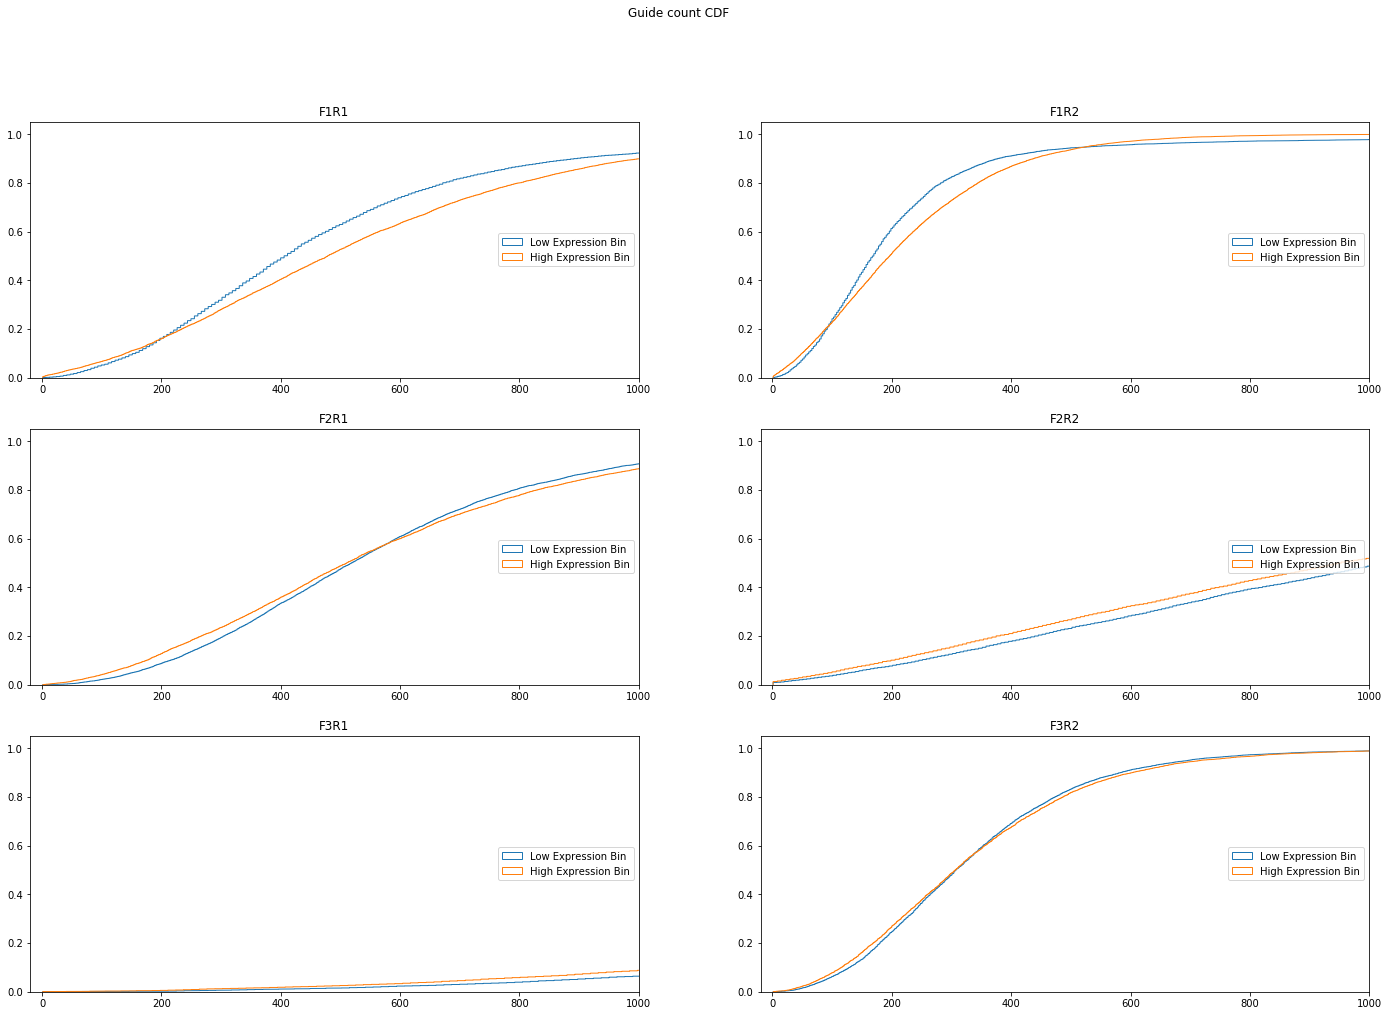

In [86]:
fig, axes = plt.subplots(3,2,figsize=(24, 16))

n_bins = 2000
# plot the cumulative histogram
for i, ax in list(enumerate(axes.flatten()))[:6]:
    n, bins, patches = ax.hist(gw_counts[i]['LS_reads'], n_bins, density=True, histtype='step',
                               cumulative=True, label='Low Expression Bin')
    n, bins, patches = ax.hist(gw_counts[i]['HS_reads'], n_bins, density=True, histtype='step',
                               cumulative=True, label='High Expression Bin')

    ax.set_xlim(-20,1000)#min(max(gw_counts[i]['HS_reads'])-10,max(gw_counts[i]['LS_reads'])-10))
    ax.legend(loc='right')
    ax.set_title(exp_ids[i])
fig.suptitle('Guide count CDF')
plt.show()

# Pick some guides

In [87]:
data

,F1R1,F1R2,F2R1,F2R2,F3R1,F3R2,FnR1,FnR2,cutsite
Coordinates,,,,,,,,,
chr11:61788524-61788546:-,-0.444506,-0.717688,-0.446532,-0.424917,-0.208398,-0.215305,0.094273,0.597376,61788527
chr11:61788527-61788549:-,-0.585573,-0.444525,0.150981,-0.064382,-0.342371,-0.060320,-0.541011,0.875115,61788530
chr11:61788560-61788582:+,-0.413584,-0.326756,-0.752557,-0.219445,-0.108891,-0.073516,-0.351929,0.512321,61788578
chr11:61788568-61788590:+,-0.803122,-0.093714,-0.186454,0.295908,-0.304052,-0.410123,0.498659,0.098764,61788586
chr11:61788568-61788590:-,-0.682111,-1.208815,-0.347912,-0.037850,-0.265037,-0.103503,1.007308,0.525244,61788571
chr11:61788583-61788605:-,-1.077559,-0.293761,-0.322129,0.030937,0.318053,0.171850,-0.013606,0.608911,61788586
chr11:61788622-61788644:+,0.052388,-0.556209,-0.362758,0.025064,-0.301970,-0.013202,0.422857,0.572311,61788640
chr11:61788630-61788652:+,-0.498486,-0.488097,0.161138,-0.121361,0.040588,0.324861,5.288267,-4.110874,61788648
chr11:61788645-61788667:-,-0.794401,-1.030263,-0.401473,-0.349295,-0.040351,-0.619039,2.616834,1.248847,61788648


FADS1
2
FADS2
1
FADS3
6


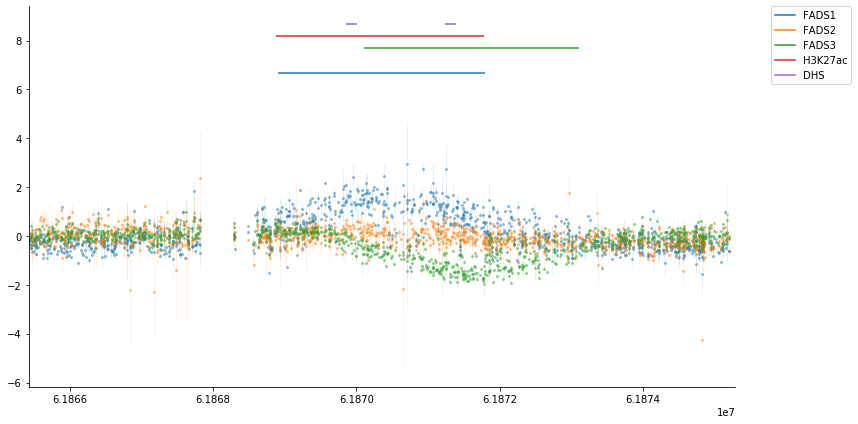

In [88]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61865430,61875290]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


FADS1
0
FADS2
0
FADS3
1


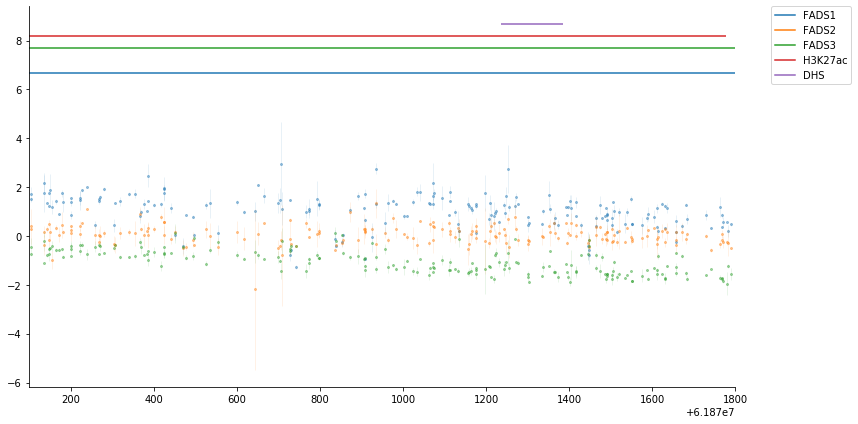

In [89]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61870100,61871800]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


In [90]:
hold_guides = data.loc[ (data['cutsite'] >= 61870100) & (data['cutsite'] < 61871800), 
                        ('F1R1','F1R2','F3R1','F3R2','cutsite') ]

hold_guides['F1_gap'] = np.abs(hold_guides['F1R1'] - hold_guides['F1R2'])
hold_guides['F3_gap'] = np.abs(hold_guides['F3R1'] - hold_guides['F3R2'])

hold_guides['F1_mean'] = (hold_guides['F1R1'] + hold_guides['F1R2']) / 2
hold_guides['F3_mean'] = (hold_guides['F3R1'] + hold_guides['F3R2']) / 2

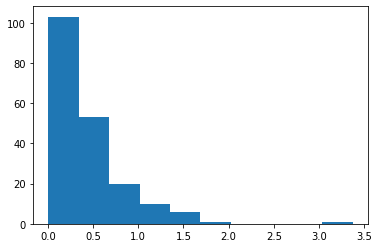

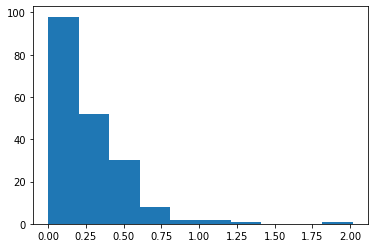

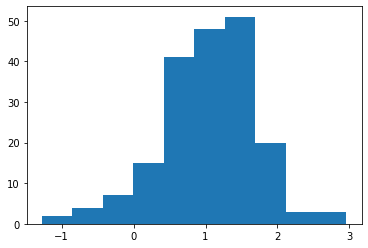

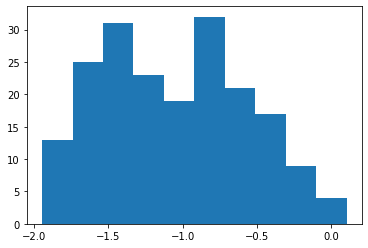

In [91]:
plt.hist( hold_guides['F1_gap'] )
plt.show()

plt.hist( hold_guides['F3_gap'] )
plt.show()

plt.hist( hold_guides['F1_mean'] )
plt.show()

plt.hist( hold_guides['F3_mean'] )
plt.show()

In [92]:
grab_guides = hold_guides[ (hold_guides['F1_gap'] < np.percentile(hold_guides['F1_gap'], 80)) & 
                           (hold_guides['F3_gap'] < np.percentile(hold_guides['F3_gap'], 80)) &
                           (hold_guides['F1_mean'] > np.percentile(hold_guides['F1_mean'], 65)) & 
                           (hold_guides['F3_mean'] < np.percentile(hold_guides['F3_mean'], 35)) ]

grab_guides

,F1R1,F1R2,F3R1,F3R2,cutsite,F1_gap,F3_gap,F1_mean,F3_mean
Coordinates,,,,,,,,,
chr11:61870931-61870953:-,2.516544,2.998229,-1.223626,-1.508375,61870934,0.481685,0.284749,2.757386,-1.366000
chr11:61870965-61870987:+,1.252763,1.391599,-1.251662,-1.453647,61870983,0.138836,0.201984,1.322181,-1.352654
chr11:61871022-61871044:-,1.286622,1.494183,-1.588882,-1.294599,61871025,0.207561,0.294283,1.390403,-1.441741
chr11:61871030-61871052:-,1.616818,2.009332,-1.657110,-1.266532,61871033,0.392514,0.390579,1.813075,-1.461821
chr11:61871054-61871076:+,1.114613,1.536235,-1.447518,-1.482686,61871072,0.421622,0.035168,1.325424,-1.465102
chr11:61871059-61871081:-,1.372463,1.332685,-1.393209,-1.806797,61871062,0.039778,0.413588,1.352574,-1.600003
chr11:61871094-61871116:+,1.559007,2.053466,-1.393658,-1.365927,61871112,0.494459,0.027731,1.806237,-1.379793
chr11:61871154-61871176:-,1.589235,1.033015,-1.406161,-1.619642,61871157,0.556220,0.213481,1.311125,-1.512901
chr11:61871383-61871405:+,1.175999,1.688081,-1.695409,-2.036882,61871401,0.512082,0.341473,1.432040,-1.866145


In [93]:
hand_picked = ['chr11:61871022-61871044:-','chr11:61871094-61871116:+','chr11:61871383-61871405:+','chr11:61871488-61871510:+']

In [94]:
grab_guides = hold_guides[ (hold_guides['F1_gap'] < np.percentile(hold_guides['F1_gap'], 70)) & 
                           (hold_guides['F3_gap'] < np.percentile(hold_guides['F3_gap'], 70)) &
                           (hold_guides['F1_mean'] > np.percentile(hold_guides['F1_mean'], 30)) & 
                           (hold_guides['F3_mean'] < np.percentile(hold_guides['F3_mean'], 15)) ]

grab_guides

,F1R1,F1R2,F3R1,F3R2,cutsite,F1_gap,F3_gap,F1_mean,F3_mean
Coordinates,,,,,,,,,
chr11:61871379-61871401:+,1.116712,1.227546,-1.517891,-1.815857,61871397,0.110834,0.297966,1.172129,-1.666874
chr11:61871471-61871493:+,1.132286,1.189584,-1.630065,-1.918759,61871489,0.057299,0.288694,1.160935,-1.774412
chr11:61871473-61871495:+,0.793582,0.963793,-1.570863,-1.728983,61871491,0.170211,0.158120,0.878687,-1.649923
chr11:61871520-61871542:+,0.816830,1.141841,-1.584822,-1.570472,61871538,0.325011,0.014350,0.979335,-1.577647
chr11:61871725-61871747:-,1.062055,0.668083,-1.620644,-1.588227,61871728,0.393971,0.032418,0.865069,-1.604436
chr11:61871765-61871787:-,0.957072,0.752236,-1.663446,-1.841631,61871768,0.204836,0.178186,0.854654,-1.752539


In [95]:
hand_picked.append('chr11:61871471-61871493:+')

In [96]:
grab_guides = hold_guides[ (hold_guides['F1_gap'] < np.percentile(hold_guides['F1_gap'], 70)) & 
                           (hold_guides['F3_gap'] < np.percentile(hold_guides['F3_gap'], 70)) &
                           (hold_guides['F1_mean'] > np.percentile(hold_guides['F1_mean'], 85)) & 
                           (hold_guides['F3_mean'] < np.percentile(hold_guides['F3_mean'], 70)) ]

grab_guides

,F1R1,F1R2,F3R1,F3R2,cutsite,F1_gap,F3_gap,F1_mean,F3_mean
Coordinates,,,,,,,,,
chr11:61870338-61870360:-,1.624112,1.813382,-0.895339,-0.813604,61870341,0.189270,0.081735,1.718747,-0.854472
chr11:61870351-61870373:-,1.918651,1.542229,-0.728686,-0.942237,61870354,0.376422,0.213551,1.730440,-0.835462
chr11:61870632-61870654:+,2.033772,2.112964,-0.925812,-0.671486,61870650,0.079193,0.254326,2.073368,-0.798649
chr11:61870931-61870953:-,2.516544,2.998229,-1.223626,-1.508375,61870934,0.481685,0.284749,2.757386,-1.366000
chr11:61871056-61871078:+,1.560076,1.942800,-1.368657,-1.263458,61871074,0.382724,0.105199,1.751438,-1.316058
chr11:61871094-61871116:+,1.559007,2.053466,-1.393658,-1.365927,61871112,0.494459,0.027731,1.806237,-1.379793


In [97]:
hand_picked.append('chr11:61870338-61870360:-')

In [98]:
hand_picked

['chr11:61871022-61871044:-',
 'chr11:61871094-61871116:+',
 'chr11:61871383-61871405:+',
 'chr11:61871488-61871510:+',
 'chr11:61871471-61871493:+',
 'chr11:61870338-61870360:-']

In [99]:
gw_counts[0][ gw_counts[0]['Coordinates'].isin(hand_picked) ]

,Coordinates,HS_reads,LS_reads,exp_id
7214,chr11:61870338-61870360:-,231,1167,F1R1
7274,chr11:61871022-61871044:-,224,811,F1R1
7285,chr11:61871094-61871116:+,121,580,F1R1
7325,chr11:61871383-61871405:+,87,282,F1R1
7339,chr11:61871471-61871493:+,145,453,F1R1
7343,chr11:61871488-61871510:+,125,506,F1R1


In [100]:
gw_counts[1][ gw_counts[0]['Coordinates'].isin(hand_picked) ]

,Coordinates,HS_reads,LS_reads,exp_id
7214,chr11:61870338-61870360:-,122,748,F1R2
7274,chr11:61871022-61871044:-,79,352,F1R2
7285,chr11:61871094-61871116:+,38,304,F1R2
7325,chr11:61871383-61871405:+,22,119,F1R2
7339,chr11:61871471-61871493:+,28,92,F1R2
7343,chr11:61871488-61871510:+,67,262,F1R2


In [101]:
gw_counts[4][ gw_counts[0]['Coordinates'].isin(hand_picked) ]

,Coordinates,HS_reads,LS_reads,exp_id
7214,chr11:61870338-61870360:-,8478,3464,F3R1
7274,chr11:61871022-61871044:-,7367,1504,F3R1
7285,chr11:61871094-61871116:+,4634,1150,F3R1
7325,chr11:61871383-61871405:+,3144,577,F3R1
7339,chr11:61871471-61871493:+,5094,998,F3R1
7343,chr11:61871488-61871510:+,5804,1163,F3R1


In [102]:
gw_counts[5][ gw_counts[0]['Coordinates'].isin(hand_picked) ]

,Coordinates,HS_reads,LS_reads,exp_id
7214,chr11:61870338-61870360:-,749,332,F3R2
7274,chr11:61871022-61871044:-,780,214,F3R2
7285,chr11:61871094-61871116:+,486,124,F3R2
7325,chr11:61871383-61871405:+,252,33,F3R2
7339,chr11:61871471-61871493:+,545,80,F3R2
7343,chr11:61871488-61871510:+,560,156,F3R2


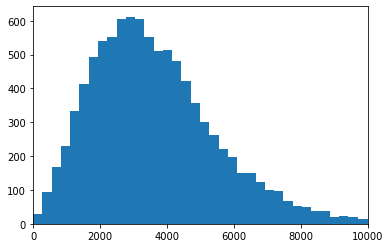

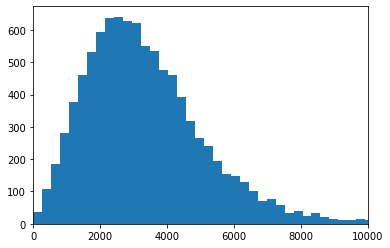

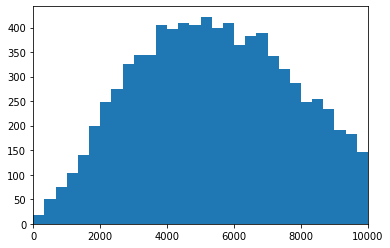

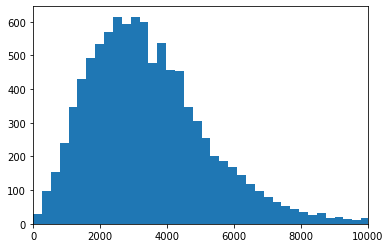

In [103]:
for i in [0,1,4,5]:
    plt.hist( gw_counts[i]['HS_reads'] + gw_counts[4]['LS_reads'],bins = 100 )
    plt.xlim(0,10000)
    plt.show()